In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!nvidia-smi

Wed Apr 13 09:04:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Train Unet

In [2]:
!date
!unzip -qq /content/drive/MyDrive/AIProject/SEAM/VOC2012/VOC2012.zip
!unzip -qq /content/drive/MyDrive/AIProject/SEAM/VOC2012/train.zip
!unzip -qq /content/drive/MyDrive/AIProject/SEAM/VOC2012/val.zip
!date

Wed Apr 13 09:02:27 UTC 2022
Wed Apr 13 09:03:37 UTC 2022


In [5]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.4 MB/s 


In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import cv2
from argparse import ArgumentParser
import os
import sys
sys.path.append('/content/drive/MyDrive/AIProject/SEAM/Unet')
from model import Attn_Unet, EffAttnUnet
from dataset import Dataset
import logging
from hparams import hparams
from losses import Semantic_loss_functions

# os.environ['CUDA_VISIBLE_DEVICES'] = hparams['gpu']
# gpu_devices = tf.config.experimental.list_physical_devices('GPU')
# for device in gpu_devices:
#     tf.config.experimental.set_memory_growth(device, True)


In [2]:
# Get data
train_gen = Dataset(mode='train')
val_gen = Dataset(mode='val')
print("TRAINING DATA: %d SAMPLES"%(len(train_gen)*hparams['batch_size']))
print("VALIDATION DATA: %d SAMPLES"%(len(val_gen)*hparams['batch_size']))

TRAINING DATA: 10572 SAMPLES
VALIDATION DATA: 1440 SAMPLES


In [4]:
# define model
model = Attn_Unet(hparams['image_shape'], 'mobilenet').make_model()
# model = EffAttnUnet(hparams['image_shape']).make_model()
with open(os.path.join(hparams['model_dir'], 'model.json'), 'w') as f:
    f.write(model.to_json())
# model.summary()

In [9]:
# define loss, optimizer and callbacks
SL = Semantic_loss_functions()
def loss_fn(ytrue, ypred):
    n, h, w, c = ypred.shape
    ytrue_focal = tf.keras.layers.Reshape((-1, c))(ytrue)
    ypred_focal = tf.keras.layers.Reshape((-1, c))(ypred)
    # bce_loss = tf.keras.losses.categorical_crossentropy(
    #     ytrue, ypred, from_logits=False)
    f_loss = tfa.losses.SigmoidFocalCrossEntropy(from_logits = False,
    alpha = 0.5, gamma = 1.5)(ytrue_focal, ypred_focal)
#     f_loss = SL.focal_loss(ytrue, ypred)
    d_loss = SL.dice_loss(ytrue, ypred) 
#     t_loss = SL.focal_tversky(ytrue, ypred)
    # return d_loss + tf.reduce_mean(bce_loss)
    return tf.reduce_mean(f_loss) + d_loss

learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    hparams['base_lr'], 3000, hparams['end_lr'], power=0.9)

optim = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn,)
ckpt = tf.keras.callbacks.ModelCheckpoint(os.path.join(hparams['model_dir'],
                                          'weights.{epoch:02d}_{val_loss:.3f}.h5'),
                                          mode='min', monitor='val_loss',
                                          save_best_only=True, save_weights_only=True)
miou_fn = tf.keras.metrics.MeanIoU(21)
def miou(ytrue, ypred):
    ytrue_logits = tf.argmax(ytrue, -1)
    ypred_logits = tf.argmax(ypred, -1)
    return miou_fn(ytrue_logits, ypred_logits)

tfboard = tf.keras.callbacks.TensorBoard(hparams['log_dir'])

semantic loss functions initialized


In [ ]:
# train:
model.compile(loss=loss_fn, optimizer=optim, metrics=[miou])
model.fit(train_gen, epochs=hparams['epoch'], batch_size=hparams['batch_size'],
        callbacks=[ckpt, tfboard], validation_data=val_gen)

Epoch 1/100
881/881 [==============================] - 1655s 2s/step - loss: 1.0423 - miou: 0.0689 - val_loss: 1.4855 - val_miou: 0.0754
Epoch 2/100
 55/881 [>.............................] - ETA: 23:41 - loss: 0.8807 - miou: 0.0733

## Test

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import os
from time import time
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.ERROR)
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

def log(txt, name, flag):
    with open(txt, 'a') as f:
        f.write('%s\t%d\n'%(name, int(flag)))

In [ ]:
json = 'trained_models/model.json'
h5 = 'trained_models/weights.61_1.145.h5'
with open(json, 'r') as f:
    model = tf.keras.models.model_from_json(f.read())
model.load_weights(h5)

# savedmodel = 'trained_models/mbnet_savedmodel'
# model.save(savedmodel)
# model = tf.saved_model.load(savedmodel)


In [ ]:
def color_map(N=256, normalized=False):
    def bitget(byteval, idx):
        return ((byteval & (1 << idx)) != 0)

    dtype = 'float32' if normalized else 'uint8'
    cmap = np.zeros((N, 3), dtype=dtype)
    for i in range(N):
        r = g = b = 0
        c = i
        for j in range(8):
            r = r | (bitget(c, 0) << 7-j)
            g = g | (bitget(c, 1) << 7-j)
            b = b | (bitget(c, 2) << 7-j)
            c = c >> 3

        cmap[i] = np.array([r, g, b])

    cmap = cmap/255 if normalized else cmap
    return cmap


def color_map_viz():
    labels = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
              'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant',
              'sheep', 'sofa', 'train', 'tvmonitor', 'void']
    nclasses = 21
    row_size = 50
    col_size = 500
    cmap = color_map()
    array = np.empty((row_size*(nclasses+1), col_size, cmap.shape[1]), dtype=cmap.dtype)
    for i in range(nclasses):
        array[i*row_size:i*row_size+row_size, :] = cmap[i]
    array[nclasses*row_size:nclasses*row_size+row_size, :] = cmap[-1]

    imshow(array)
    plt.yticks([row_size*i+row_size/2 for i in range(nclasses+1)], labels)
    plt.xticks([])
    plt.show()
    
cmap = color_map()

In [ ]:
filelist = '/data/sonnh8/SEAM/VOCdevkit/VOC2012/ImageSets/Segmentation/test.txt'
with open(filelist, 'r') as f:
    names = f.read().split('\n')
root = '/data/sonnh8/SEAM/VOCdevkit/VOC2012'

im_size = (448, 448)
view = True
for name in names:
    fp = os.path.join(root, "JPEGImages", name + '.jpg')
    label_path = os.path.join(root, "SegmentationClass", name + '.png')
    img = cv2.imread(fp)
    img = cv2.resize(img, (im_size[1], im_size[0]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    im = img / 255.0
    tensor = tf.expand_dims(im.astype('float32'), 0)
    s = time()
    mask = model(tensor)[0].numpy()#.astype('uint8')
    mask[0,:,:] = 0.26
    mask = np.argmax(mask, -1)
    
    segment_map = cmap[mask]
    label = cv2.imread(label_path)
    label = cv2.resize(label, (im_size[1], im_size[0]))
    if view:
        plt.figure(131)
        plt.imshow(img)
        plt.figure(132)
        plt.imshow(segment_map)
        plt.figure(133)
        plt.imshow(label)
        plt.show()
        input()


error: OpenCV(4.5.2) /tmp/pip-req-build-x6vvo8fj/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


2008_005501.npy


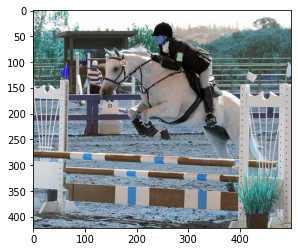

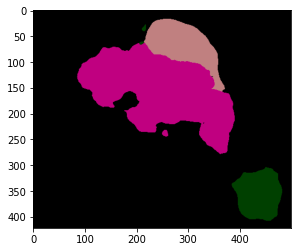

KeyboardInterrupt: Interrupted by user

In [ ]:
path = '/data/sonnh8/SEAM/VOCdevkit/VOC2012/JPEGImages'
mask_path = '/data/sonnh8/SEAM/SEAM/Result/train_aug_cam'   
# save_path = '/data/sonnh8/SEAM/SEAM/Result/val_viz'

def load_np(predict_file):
    predict_dict = np.load(predict_file, allow_pickle=True).item()
    h, w = list(predict_dict.values())[0].shape
    tensor = np.zeros((21,h,w),np.float32)
    for key in predict_dict.keys():
        tensor[key+1] = predict_dict[key]
    tensor[0,:,:] = 0.26
    predict = np.argmax(tensor, axis=0).astype(np.uint8)
    return predict

for name in os.listdir(mask_path):
    print(name)
    fp = os.path.join(mask_path, name)
    im_path = os.path.join(path, name[:-3]+'jpg')
    img = cv2.imread(im_path)
#     mask = cv2.imread(fp, cv2.IMREAD_UNCHANGED)
    mask = load_np(fp)
    segment_map = cmap[mask]
#     segment_map = cv2.cvtColor(segment_map, cv2.COLOR_BGR2RGB)
#     cv2.imwrite(os.path.join(save_path, name), segment_map)
    plt.figure(211)
    plt.imshow(img)
    plt.figure(212)
    plt.imshow(segment_map)
    plt.show()
    input()